In [1]:
import numpy as np
from sklearn.datasets import fetch_20newsgroups
train=fetch_20newsgroups(subset='train')
test=fetch_20newsgroups(subset='test')

In [2]:
from nltk.tokenize import word_tokenize
word_data_train=list(map(word_tokenize,train['data']))
word_data_test=list(map(word_tokenize,test['data']))

In [3]:
word_data_train[0][:20]

['From',
 ':',
 'lerxst',
 '@',
 'wam.umd.edu',
 '(',
 'where',
 "'s",
 'my',
 'thing',
 ')',
 'Subject',
 ':',
 'WHAT',
 'car',
 'is',
 'this',
 '!',
 '?',
 'Nntp-Posting-Host']

In [4]:
from gensim.models.word2vec import Word2Vec

In [5]:
model = Word2Vec(word_data_train,size=10,window=5,max_vocab_size=2000,sg=1,negative=5)

- size:結果として出てくる次元
    - 50000単語で100次元とかだから10にしとこうかな、と思った
    - 基本はコーパスの長さで決める
    - 根拠はない。
- window:窓幅
- max_vocab_size:多い順にいくつの単語を使うか
    - bowのときと揃えてみた。
- sg:skip-gramモデルを使うか(=1)、CBOWを使うか(=0)
- hs:階層的ソフトマックスを使うか
- negative:負例サンプリングを何％やるか

In [6]:
model.wv['I']

array([-0.33299091,  0.36517087,  0.56925631,  0.02745426, -0.7085253 ,
        0.51154071,  0.03415048, -0.37912712,  0.56840569, -0.08538905], dtype=float32)

In [7]:
model.wv['I'].shape

(10,)

- ちゃんと10次元。

In [8]:
model.wv.most_similar(positive=['I'])

[('sure', 0.9221671223640442),
 ('like', 0.9069490432739258),
 ('just', 0.9042322635650635),
 ('trying', 0.8970909118652344),
 ('my', 0.8970806002616882),
 ('me', 0.8958888053894043),
 ('about', 0.8928702473640442),
 ('post', 0.8818342685699463),
 ("'m", 0.8776397705078125),
 ('if', 0.8770508766174316)]

- ちゃんと主語っぽい。

In [9]:
model.wv.most_similar_cosmul(positive=['I'])

[('sure', 0.9610826373100281),
 ('like', 0.9534736275672913),
 ('just', 0.9521151781082153),
 ('trying', 0.9485445618629456),
 ('my', 0.9485393762588501),
 ('me', 0.9479434490203857),
 ('about', 0.9464341998100281),
 ('post', 0.9409162402153015),
 ("'m", 0.9388189315795898),
 ('if', 0.9385245442390442)]

- ユークリッド距離よりもコサイン類似度の方が良かったりすることもある。
- 今回は全く変わらなかった。

### 「和を取るだけ」を試す

In [10]:
import tqdm

In [11]:
train_vectors=np.zeros((len(word_data_train),10))

for i,words in enumerate(tqdm.tqdm(word_data_train)):
    for word in words:
        train_vectors[i]+=model.wv[word]

  0%|          | 0/11314 [00:00<?, ?it/s]


KeyError: "word 'lerxst' not in vocabulary"

- こういうことがよくある。
- modelに目当ての単語がないというパターン。

In [12]:
wordset=set(model.wv.vocab.keys())

In [15]:
train_vectors=np.zeros((len(word_data_train),10))

for i,words in enumerate(tqdm.tqdm(word_data_train)):
    for word in words:
        if word in wordset:
            train_vectors[i]+=model.wv[word]

100%|██████████| 11314/11314 [00:16<00:00, 697.97it/s]


- if ~ in ~を使うとき
    - 間違ってもlistにinを使わないようにしよう
    - setとかdictionaryのkeyとかは速い印象。

In [13]:
wordlist=list(model.wv.vocab.keys())

In [14]:
train_vectors=np.zeros((len(word_data_train),10))

for i,words in enumerate(tqdm.tqdm(word_data_train)):
    for word in words:
        if word in wordlist:
            train_vectors[i]+=model.wv[word]

100%|██████████| 11314/11314 [00:47<00:00, 240.53it/s]


- これはダメ。
    - 今回は倍くらい遅かった
    - 単語数次第ではもっと遅くなる

In [16]:
test_vectors=np.zeros((len(word_data_test),10))

for i,words in enumerate(tqdm.tqdm(word_data_test)):
    for word in words:
        if word in wordset:
            test_vectors[i]+=model.wv[word]

100%|██████████| 7532/7532 [00:08<00:00, 851.15it/s]


### bowと同じ手法で比較する

In [18]:
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier

In [19]:
clf_list=[RidgeClassifier(),RandomForestClassifier(n_estimators=100)]
clf_names=['L2正則化つきの線形分類器','ランダムフォレスト']

for name,clf in zip(clf_names,clf_list):
    clf.fit(train_vectors,train['target'])
    print(name,'：',clf.score(test_vectors,test['target']))

L2正則化つきの線形分類器 ： 0.127057886352
ランダムフォレスト ： 0.170738183749


- ワンチャン単語削りすぎた。

- 参考記録：BOW
    - L2正則化つきの線形分類器 ： 0.629978757302
    - ランダムフォレスト ： 0.699548592671
    - rbfカーネルのSVM ： 0.502389803505
    - 2次の多項カーネルのSVM ： 0.0677110993096

In [24]:
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.manifold import TSNE

In [25]:
tsne=TSNE()

In [26]:
emb=tsne.fit_transform(train_vectors)

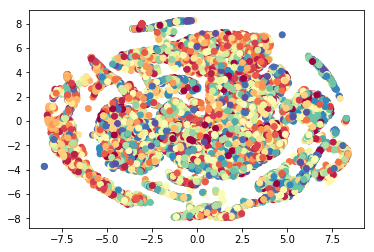

In [27]:
plt.scatter(*emb.T,c=train['target'],cmap='Spectral')

In [29]:
model = Word2Vec(word_data_train,sg=1)

In [30]:
model.vector_size

100

In [31]:
wordset=set(model.wv.vocab.keys())

train_vectors=np.zeros((len(word_data_train),model.vector_size))

for i,words in enumerate(tqdm.tqdm(word_data_train)):
    for word in words:
        if word in wordset:
            train_vectors[i]+=model.wv[word]
            
            
test_vectors=np.zeros((len(word_data_test),model.vector_size))

for i,words in enumerate(tqdm.tqdm(word_data_test)):
    for word in words:
        if word in wordset:
            test_vectors[i]+=model.wv[word]

100%|██████████| 7532/7532 [00:14<00:00, 532.10it/s]


In [32]:
clf_list=[RidgeClassifier(),RandomForestClassifier(n_estimators=100)]
clf_names=['L2正則化つきの線形分類器','ランダムフォレスト']

for name,clf in zip(clf_names,clf_list):
    clf.fit(train_vectors,train['target'])
    print(name,'：',clf.score(test_vectors,test['target']))

L2正則化つきの線形分類器 ： 0.466144450345
ランダムフォレスト ： 0.456186935741
